# Cluster-Based Coverage Analysis: LAION vs THINGS and NSD

This notebook analyzes how well existing datasets (THINGS and NSD) cover the cluster space defined by LAION-natural. It uses k-means cluster centers generated from LAION samples to create a reference space, then examines which clusters are represented by each dataset.

**Prerequisites:** Run `cluster_laion.py` first to generate cluster centers from LAION samples.

In [3]:
import os
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE

from how_to_sample.data import DataAccessor, load_pickle_file, save_pickle_file

## Clustering Methodology

The cluster centers used in this analysis are generated using the following process:

1. **Sample Selection**: 10 million images randomly sampled from LAION-2B
2. **Natural Image Filtering**: Images filtered using a natural image classifier (threshold = 0.75)
3. **Feature Extraction**: CLIP visual features extracted for filtered images
4. **K-means Clustering**: 5,443 clusters created using MiniBatch K-means
5. **Cluster Centers**: Final cluster centers saved as reference points for coverage analysis

This creates a representative clustering of the LAION-natural feature space that serves as our reference for measuring dataset coverage.


## Load data

In [4]:
state_dir = (
    Path(
        "/u/rothj/laion_natural/experiments/laion/embedding_space/notebooks/notebook_states"
    )
    / "cluster_comparison"
)
state_dir.mkdir(parents=True, exist_ok=True)

In [5]:
# Path to cluster centers generated by cluster_laion.py
clustering_result_dir = "../outputs/cluster_laion"
plot_out_dir = "outputs/nsd_things_cluster_comparisons"

In [ ]:
# Load cluster centers generated by cluster_laion.py
cluster_centers = np.load(os.path.join(clustering_result_dir, "cluster_centers.npy"))

In [ ]:
data_accessor = DataAccessor()
things_features, things_image_accessor = data_accessor.load_dataset("things")
nsd_features, nsd_image_accessor = data_accessor.load_dataset("nsd")

In [7]:
feature_sets = {
    "things": things_features,
    "nsd": nsd_features,
}

In [8]:
feature_distances = {
    dataset: cdist(feature_sets[dataset], cluster_centers) for dataset in feature_sets
}

cluster_assignments = {
    dataset: np.argmin(feature_distances[dataset], axis=1) for dataset in feature_sets
}

save_pickle_file(cluster_assignments, state_dir / "cluster_assignments.pkl")

In [9]:
cluster_assignments = load_pickle_file(state_dir / "cluster_assignments.pkl")

In [10]:
unique_clusters = {
    dataset: np.unique(cluster_assignments[dataset]) for dataset in feature_sets
}

In [11]:
cluster_sizes = {
    dataset: np.bincount(cluster_assignments[dataset], minlength=len(cluster_centers))
    for dataset in feature_sets
}

## Plot coverage of clusters in TSNE space

In [14]:
min_images_per_cluster = 10
things_threshold = min_images_per_cluster
nsd_threshold = min_images_per_cluster

# Create categories based on representation
things_mask = cluster_sizes["things"] > things_threshold
nsd_mask = cluster_sizes["nsd"] > nsd_threshold

both_mask_indices = np.where(things_mask & nsd_mask)[0]
things_only_mask_indices = np.where(things_mask & ~nsd_mask)[0]
nsd_only_mask_indices = np.where(nsd_mask & ~things_mask)[0]
neither_mask_indices = np.where(~things_mask & ~nsd_mask)[0]

In [24]:
# Create TSNE projection
tsne = TSNE(n_components=2, random_state=42)
cluster_centers_2d = tsne.fit_transform(cluster_centers)

save_pickle_file(cluster_centers_2d, state_dir / "cluster_centers_2d.pkl")

In [25]:
cluster_centers_2d = load_pickle_file(state_dir / "cluster_centers_2d.pkl")

In [26]:
# Calculate ratio of THINGS to NSD representation and create masks
epsilon = 1e-10

min_images_per_cluster = 2
things_threshold = min_images_per_cluster  # / len(things_features)
nsd_threshold = min_images_per_cluster  # / len(nsd_features)

things_nsd_ratio = np.log2(
    (cluster_sizes["things"] + epsilon) / (cluster_sizes["nsd"] + epsilon)
)
things_mask = cluster_sizes["things"] > things_threshold
nsd_mask = cluster_sizes["nsd"] > nsd_threshold
both_mask = (things_mask) & (nsd_mask)
neither_mask = (cluster_sizes["things"] <= things_threshold) & (
    cluster_sizes["nsd"] <= nsd_threshold
)

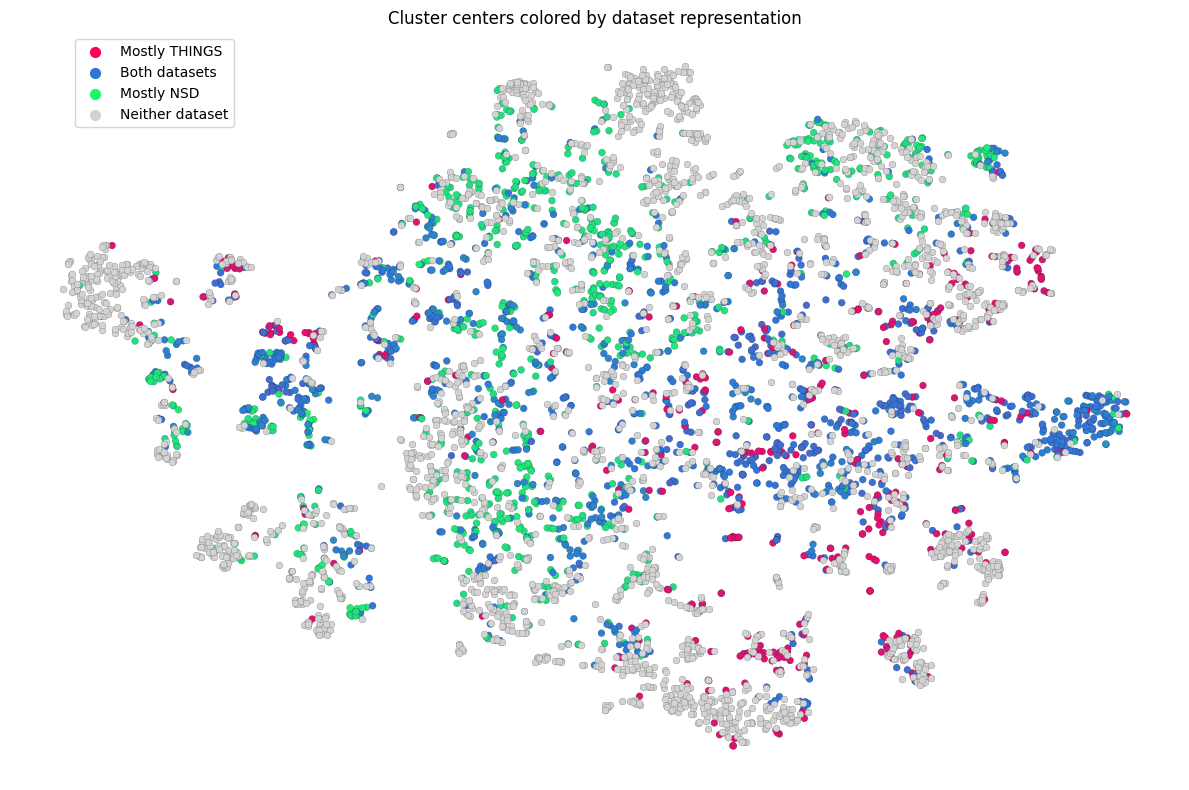

In [30]:
# Create figure
plt.figure(figsize=(12, 8))


# colors = ["#3076D8", "#FF001E", "#0E8A3C", "#D3D3D3"]

# Create legend handles for the colored regions
legend_elements = [
    plt.scatter([], [], c="#FF005D", s=50, label="Mostly THINGS"),
    plt.scatter([], [], c="#3076D8", s=50, label="Both datasets"),
    plt.scatter([], [], c="#1FF36F", s=50, label="Mostly NSD"),
    plt.scatter([], [], c="#D3D3D3", s=50, label="Neither dataset"),
]

# Plot remaining points with ratio coloring
remaining_mask = ~neither_mask
colors = ["#1FF36F", "#3076D8", "#FF005D"]
custom_cmap = LinearSegmentedColormap.from_list("custom_diverging", colors, N=256)

max_ratio = np.max(np.abs(things_nsd_ratio))
norm = plt.Normalize(vmin=-max_ratio, vmax=max_ratio)

scatter = plt.scatter(
    cluster_centers_2d[remaining_mask, 0],
    cluster_centers_2d[remaining_mask, 1],
    c=things_nsd_ratio[remaining_mask],
    cmap=custom_cmap,
    norm=norm,
    s=25,
    alpha=1,
    edgecolor="black",
    linewidth=0.1,
)

# Plot points that are not represented in either dataset in gray
plt.scatter(
    cluster_centers_2d[neither_mask, 0],
    cluster_centers_2d[neither_mask, 1],
    c="#D3D3D3",
    s=25,
    alpha=1,
    label="Neither dataset",
    edgecolor="black",
    linewidth=0.1,
)


# Add colorbar
plt.title("Cluster centers colored by dataset representation")
plt.xlabel("TSNE dimension 1")
plt.ylabel("TSNE dimension 2")
plt.axis("off")

# Add legend with all elements
plt.legend(handles=legend_elements, bbox_to_anchor=(0.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig(
    os.path.join(plot_out_dir, "tsne_things_nsd_ratio.pdf"), bbox_inches="tight"
)
plt.show()

## Plot simple coverage percentages

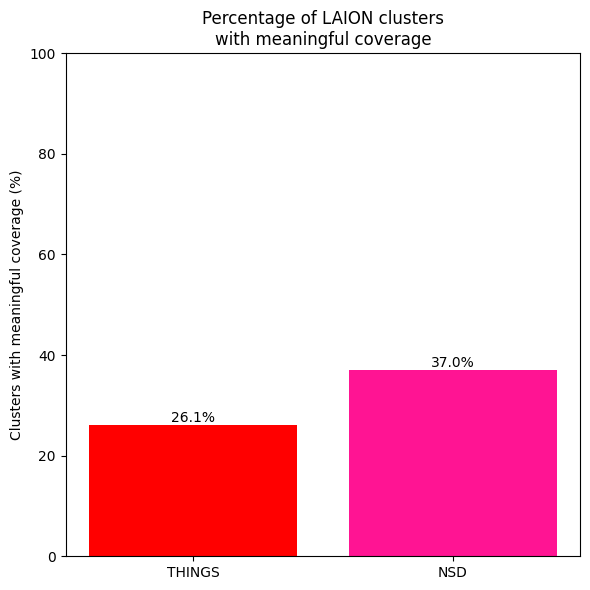

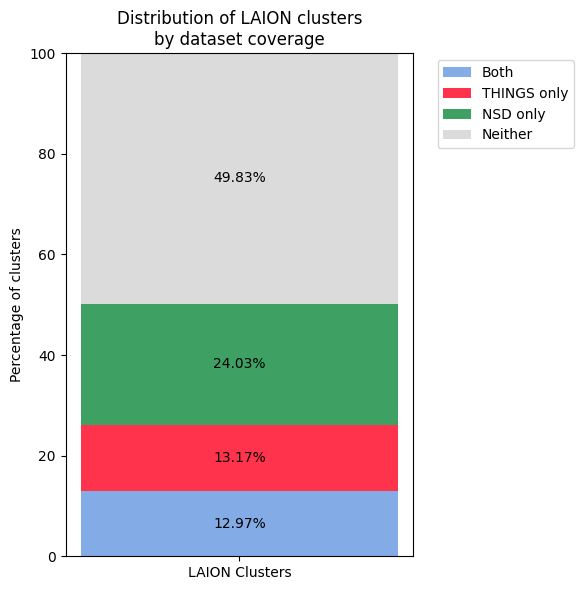

In [30]:
total_clusters = len(cluster_centers)
coverage_stats = {
    "THINGS": np.sum(things_mask) / total_clusters * 100,
    "NSD": np.sum(nsd_mask) / total_clusters * 100,
    "Both": np.sum(both_mask) / total_clusters * 100,
    "Neither": np.sum(neither_mask) / total_clusters * 100,
}

datasets = ["THINGS", "NSD"]
percentages = [coverage_stats["THINGS"], coverage_stats["NSD"]]

plt.figure(figsize=(6, 6))

categories = ["LAION Clusters"]
both_pct = coverage_stats["Both"]
things_only_pct = coverage_stats["THINGS"] - coverage_stats["Both"]
nsd_only_pct = coverage_stats["NSD"] - coverage_stats["Both"]
neither_pct = coverage_stats["Neither"]

plt.bar(categories, [both_pct], label="Both", color="#3076D8", alpha=0.6)
plt.bar(
    categories,
    [things_only_pct],
    bottom=[both_pct],
    label="THINGS only",
    color="#FF001E",
    alpha=0.8,
)
plt.bar(
    categories,
    [nsd_only_pct],
    bottom=[both_pct + things_only_pct],
    label="NSD only",
    color="#0E8A3C",
    alpha=0.8,
)
plt.bar(
    categories,
    [neither_pct],
    bottom=[both_pct + things_only_pct + nsd_only_pct],
    label="Neither",
    color="#D3D3D3",
    alpha=0.8,
)


# Add percentage labels in the middle of each segment
def add_label(pct, bottom):
    if pct > 5:  # Only show label if segment is large enough
        plt.text(0, bottom + pct / 2, f"{pct:.2f}%", ha="center", va="center")


add_label(neither_pct, both_pct + things_only_pct + nsd_only_pct)
add_label(nsd_only_pct, both_pct + things_only_pct)
add_label(things_only_pct, both_pct)
add_label(both_pct, 0)

plt.ylabel("Percentage of clusters")
plt.title("Distribution of LAION clusters\nby dataset coverage")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylim(0, 100)

plt.tight_layout()
plt.savefig(
    os.path.join(plot_out_dir, "cluster_coverage_distribution.pdf"), bbox_inches="tight"
)
plt.show()

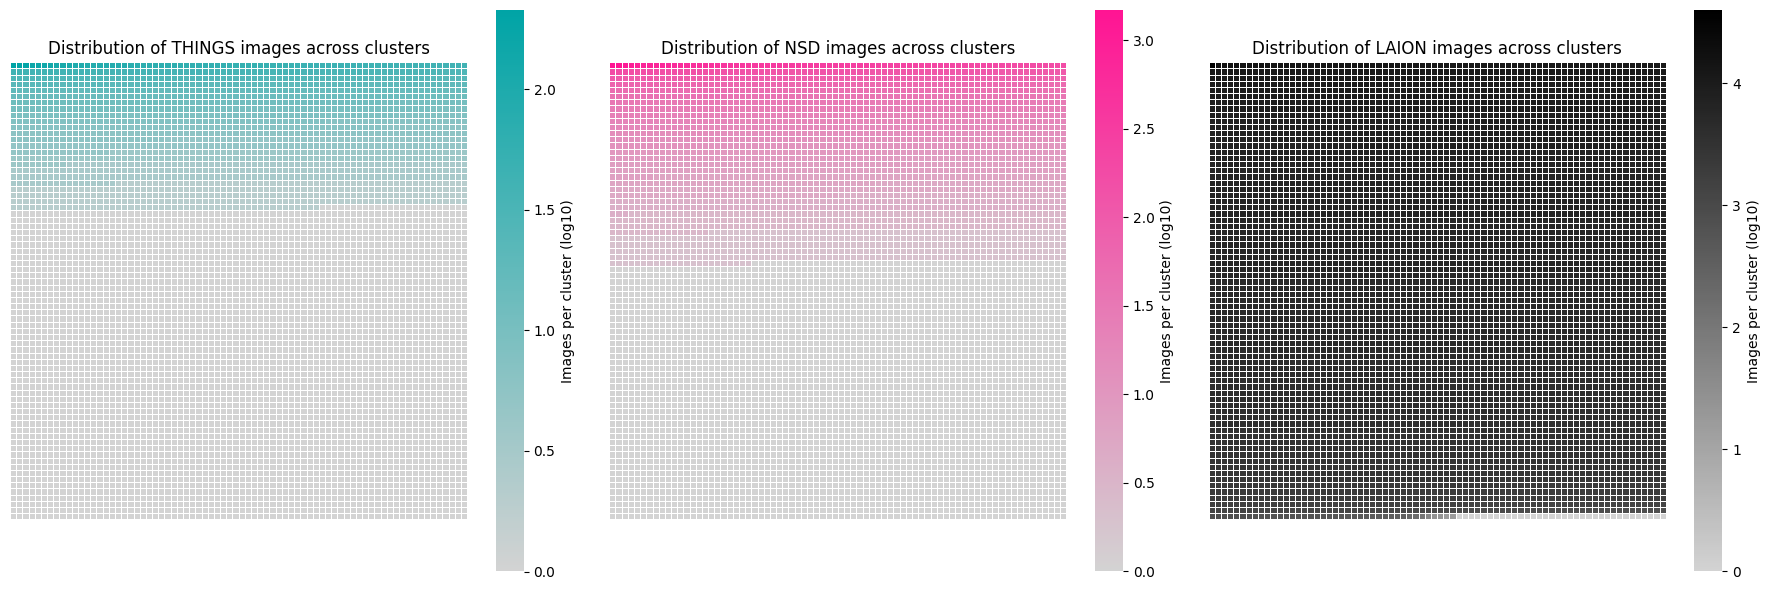

In [31]:
plt.figure(figsize=(18, 6))

# Create custom colormap from lightgray to the dataset-specific colors
colors_by_dataset = {
    "things": ["lightgray", "#00A4A6"],  # Gray to teal
    "nsd": ["lightgray", "#FF1493"],  # Gray to pink
    "laion": ["lightgray", "black"],  # Gray to blue
}

# Create subplots for each dataset
for idx, dataset in enumerate(["things", "nsd", "laion"]):
    plt.subplot(1, 3, idx + 1)

    # Create dataset-specific colormap
    cmap = LinearSegmentedColormap.from_list(
        f"custom_{dataset}", colors_by_dataset[dataset]
    )

    # Reshape the data into a roughly square grid
    n_clusters = len(cluster_sizes[dataset])
    sorted_sizes = sorted(cluster_sizes[dataset])[::-1]
    grid_size = int(np.ceil(np.sqrt(n_clusters)))
    grid_data = np.zeros((grid_size, grid_size))

    # Fill the grid with cluster sizes
    for i in range(min(n_clusters, grid_size * grid_size)):
        row = i // grid_size
        col = i % grid_size
        grid_data[row, col] = sorted_sizes[i]

    # Create heatmap with log scale for better visualization
    grid_data_log = np.log10(grid_data + 1e-10)

    # Get actual min/max values for proper scaling
    vmin = np.min(
        grid_data_log[grid_data_log > -10]
    )  # Ignore the -inf values from zeros
    vmax = np.max(grid_data_log)

    # Plot heatmap with more distinct boundaries
    sns.heatmap(
        grid_data_log,
        cmap=cmap,
        cbar_kws={"label": "Images per cluster (log10)"},
        square=True,
        linewidths=0.5,
        linecolor="white",
        vmin=vmin,
        vmax=vmax,
        xticklabels=False,  # Remove x-axis ticks
        yticklabels=False,
    )  # Remove y-axis ticks

    plt.title(f"Distribution of {dataset.upper()} images across clusters")
    # Remove xlabel and ylabel
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.savefig(
    os.path.join(plot_out_dir, "cluster_sizes_heatmap_comparison.pdf"),
    bbox_inches="tight",
)
plt.show()